In [1]:
%run config.ipynb
import nltk
from nltk.corpus import stopwords
import spacy
import re

import tensorflow as tf
print("Num GPUs Available: ", tf.config.experimental.list_physical_devices('GPU'))
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Dense, Embedding, LSTM, Bidirectional, GlobalMaxPooling1D
from tensorflow.keras.models import Model, clone_model

Num GPUs Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Read Datasets

In [2]:
# business = pd.read_json("data/yelp_academic_dataset_business.json", lines=True)
# check_in = pd.read_json("data/yelp_academic_dataset_checkin.json", lines=True)
# review = pd.read_csv("data/yelp_academic_dataset_sample_review.csv")
review = pd.read_csv("data/yelp_academic_dataset_sample005_review.csv")
# tip = pd.read_json("data/yelp_academic_dataset_tip.json", lines=True)
# user = pd.read_json("data/yelp_academic_dataset_user.json", lines=True)

In [3]:
review

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,bXvOUOFJgQr7xiveQS7nIg,Oisnn5J3m4Mq2otVd1LGZw,3_NOo26lt3VArKiLcK17qQ,5,0,0,0,When it is not hot here usually during fall/wi...,2011-09-12 03:09:54
1,st2JQYRM-SMgb2QPSR9BMA,_ZrziJUfV3ZqH4H495ISnQ,TQqhfjlPVEz41K_wAogQSQ,3,0,0,0,The lasagne was slightly bland but ok. There ...,2018-11-23 23:12:39
2,LHrHBVFNgPk0cIe3UZOjHA,f6M50dZNFNFBIGarOJ8Myg,yvPkA1ZXz1M59G6e64jZGw,5,0,0,0,Nick Osborne takes his time. He cares a lot ab...,2018-04-25 01:55:31
3,HPmRc8BqOe5X5SN_tsNuaw,7KYnhbHu1Rr2HzFhFLGXxg,InYPeA1WM9uGR_mA5Wia1g,1,0,0,1,I came here with my bestfriend and it was the ...,2017-07-21 08:01:08
4,0Nx_T8MsIqjrUOtGeOJMuw,kbfpED-6FURIsNlsAXqc2g,63bHLJUomC22Xdm3IjgBtw,2,1,0,0,This might have been the rudest establishment ...,2017-08-07 22:31:10
...,...,...,...,...,...,...,...,...,...
80206,AQK1USIVHnDargrmC_mf6g,pQusQUimSS-cAozKKdbHQw,mISfQv_it_TCXpFf4BFzaw,4,2,0,0,The bartenders/servers need to do a little hom...,2012-04-21 16:41:27
80207,QSjw8FNPCOQUdMt8VdIU8g,djP46l4v0TQTqhLa-ZB1xw,UOtoOybZ5vAB4aXBLc57vA,3,2,1,2,I think this is a hit or miss kind of place. I...,2014-10-12 01:16:38
80208,NZpfUFv6RHB4KOoqnaChkA,z8wN6EQuw_JF-zTjcNgsLw,PkI1x_NCyEt2sR8MYv4l7w,5,6,6,5,I freaking hate this place!!! WHY? Because i s...,2012-10-18 01:00:24
80209,FtsXFtvfSiOwVvsi7ZsINg,Vbm50WElUT2QUYvmQ3QB4Q,Cl6hqAnuKz3ZPv5x4NGhAQ,5,0,3,0,I called their warranty department to speak wi...,2015-05-18 22:05:22


## Preprocessing

In [3]:
X = review["text"]

In [4]:
nlp = spacy.load("en_core_web_lg")

In [5]:
stop_words = set(stopwords.words('english')) 

In [6]:
# This process will a long time to run, so make sure you create a copy yourself after finish
SYMBOL_RE = re.compile('[/(){}\[\]\|@,.:!?;\-*]')
WEBSITES_RE = re.compile('http[s]?[:]?[.]?[\/]+[^.\/]+([.][^.\/\s]+)+[^\s]*')
ABBR_RE = re.compile('[a-z]*[\'][^ ]*')
def clean_text(text):
    ents = [word.text for word in nlp(text).ents if word.label_ in ['PERSON', "ORG", "GPE", "DATE", "TIME"]]
    for ent in ents:
        text = text.replace(ent, '')
    text = text.lower()
    text = WEBSITES_RE.sub('', text)

    text = ' '.join(word for word in text.split() if word not in stop_words)
    text = SYMBOL_RE.sub('', text)
    text = ABBR_RE.sub('', text)
    return text

In [ ]:
X = X.apply(clean_text)

## Split Dataset

In [ ]:
y = review["stars"]
df_train, df_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

## Word Embedding

In [ ]:
MAX_VOCAB_SIZE = 30000
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(df_train.values)
sequences_train = tokenizer.texts_to_sequences(df_train)
sequences_test = tokenizer.texts_to_sequences(df_test)

In [ ]:
word2idx = tokenizer.word_index
V = len(word2idx)
print('Found %s unique tokens.' % V)

In [ ]:
X_train = pad_sequences(sequences_train)
print('Shape of data train tensor:', X_train.shape)

T = X_train.shape[1]

X_test = pad_sequences(sequences_test, maxlen=T)
print('Shape of data test tensor:', X_test.shape)

## Modelling

In [ ]:
def fit_model(model, epochs=5, batch_size=128, loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy']):
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    r = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test))
    plot(r)
    return model, r

def plot(r):
    plt.xlabel('# epochs')
    length = len(r.history[next(iter(r.history))])
    plt.xticks(np.arange(length), np.arange(1, length+1))
    plt.plot(r.history['loss'], label='loss')
    plt.plot(r.history['val_loss'], label='val_loss')
    plt.plot(r.history['accuracy'], label='acc')
    plt.plot(r.history['val_accuracy'], 'm', label='val_acc')
    plt.legend()

def create_model():
    D = 100
    num_words = min(MAX_VOCAB_SIZE, V + 1)
    i = Input(shape=(T,))
    x = Embedding(num_words, D)(i)
    x = Bidirectional(LSTM(D//2, return_sequences=True))(x)
    x = GlobalMaxPooling1D()(x)
    x = Dense(8, activation='softmax')(x)
    model = Model(i, x)
    model.summary(120)
    return model

In [ ]:
m, r = fit_model(create_model())

Model: "functional_9"
__________________________________________________________________________________________________________________________________
Layer (type)                                              Output Shape                                        Param #             
input_6 (InputLayer)                                      [(None, 495)]                                       0                   
__________________________________________________________________________________________________________________________________
embedding_5 (Embedding)                                   (None, 495, 50)                                     1500000             
__________________________________________________________________________________________________________________________________
lstm_5 (LSTM)                                             (None, 495, 100)                                    60400               
_____________________________________________________________

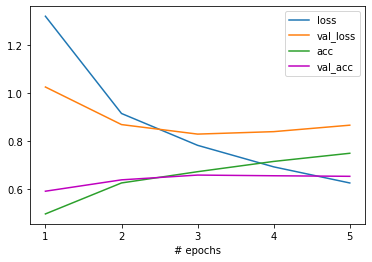

In [33]:
m1, r1 = fit_model(create_model())

Model: "functional_13"
________________________________________________________________________________________________________________________
Layer (type)                                          Output Shape                                    Param #           
input_8 (InputLayer)                                  [(None, 495)]                                   0                 
________________________________________________________________________________________________________________________
embedding_7 (Embedding)                               (None, 495, 100)                                3000000           
________________________________________________________________________________________________________________________
bidirectional_6 (Bidirectional)                       (None, 495, 100)                                60400             
________________________________________________________________________________________________________________________
global_ma

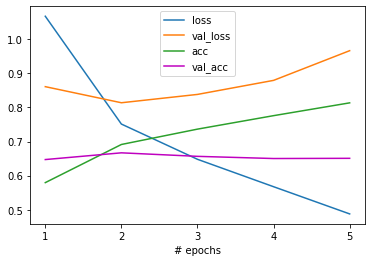

In [39]:
m2, r2 = fit_model(create_model())